In [1]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
import pdb 
import time
import matplotlib.pyplot as plt

In [2]:
def lprint(prompt, arr):
    print(prompt)
    for i, a in enumerate(arr):
        print(i)
        print(a)
        print('=================')

In [3]:
class FramesDataset(Dataset):
    def text2Tensor(self, file_data):
        #process the file data such that it's a list of lists of offset tuple in each time step
        file_data_t = []
        data_temp = []
        frame_num = file_data[0][0]
        traj_list = []
        frame_list = []
        for line in file_data:
            if frame_num != line[0]:
                frame_num = line[0]
                data_temp.sort(key=lambda data : data[1])
                file_data_t.append(data_temp)
                data_temp = [line]
            else:    
                data_temp.append(line)
            #keep a traj list for all trajs
            if line[1] not in traj_list:
                traj_list.append(line[1])
            if line[0] not in frame_list:
                frame_list.append(line[0])
        traj_list.sort()
        frame_list.sort()  
        
        #get participants in each frame
        #@note here the elements are ped's index in the traj list
        participants = [[] for i in range(len(file_data_t))]
        for frame_idx, line in enumerate(file_data_t):
            for traj_idx, traj in enumerate(traj_list):
                in_flag = False
                for data in line:
                    if data[1] == traj:
                        in_flag = True
                        participants[frame_idx].append(traj_list.index(data[1]))
                if not in_flag:
                    file_data_t[frame_idx].append([frame_list[frame_idx], traj, 0., 0.])
            file_data_t[frame_idx].sort(key=lambda data : data[1])

        file_data_tensors = torch.tensor(file_data_t, device=device)
        
        participant_masks = []
        for frame_idx, line in enumerate(participants):
            participant_masks.append([[torch.tensor(1.) if i in participants[frame_idx] else torch.tensor(0.) for i in range(len(traj_list))]])
        participant_masks = torch.tensor(participant_masks, device=device)
        
        return traj_list, participant_masks, file_data_tensors              
    
    
    '''
    @func preprocess
    @param path: relative path for the raw data
    @note raw data~ col1: frame index, col2: traj index, (col3, col4): (y, x)
    @return traj_list: indices for each trajactory in raw data
            participants_masks~tensor(frame num x traj num): indicate the presence of each ped at each frame
            file_data_tensors~tensor(frame num x traj num x 4): the position of each traj at each frame
                                                                if not present default to (0,0)
    '''
    def preprocess(self, path):
        #open the file as it is
        file_data = []
        with open(path, 'r') as file:
            for line in file:
                line_data = [int(float(data)) if i < 2 else float(data) for i, data in enumerate(line.rsplit())]
                line_data[2], line_data[3] = line_data[3], line_data[2]
                file_data.append(line_data)
        file_data_sort = sorted(file_data, key=lambda data : data[0])
        
        traj_list, participant_masks, coord_tensors = self.text2Tensor(file_data_sort)
        
        #process the file data such that it contains the offsets not global coords
        file_data_off = []
        for i, line in enumerate(file_data):
            if i > 0:
                if file_data[i][1] == file_data[i-1][1]:
                    file_data_off.append([file_data[i][0], file_data[i][1], file_data[i][2]-file_data[i-1][2], file_data[i][3]-file_data[i-1][3]])
        file_data_off.sort(key=lambda data : data[0])        
        
        traj_list, participant_masks, off_tensors = self.text2Tensor(file_data_off)
        
        return traj_list, participant_masks, off_tensors, coord_tensors
    

    def __init__(self, path):
        self.traj_list, self.participant_masks, self.off_data, self.coord_data = self.preprocess(path)
        

    def __len__(self):
        return len(self.off_data)

    '''
    @note (X, Y) is a (file_data[idx], frame[idx+1]) pair if a single idx is provided
    a (frame[idx.start]2frame[idx.end], frame[idx.start+1]2frame[idx.end+1]) pair is provided
    if a index slice is provided
    the accompanying mask tensor follows the same rule 
    '''
    def __getitem__(self, idx):
        if isinstance(idx, int):
            if idx < len(self.off_data)-1:
                Y_idx = idx+1
            else:
                Y_idx = len(self.off_data)-1
            Z_idx = idx
            X_idx = idx

        else:
            if idx.start != None:
                start = idx.start+1
            else:
                start = 0+1
#             if idx.stop != None:
#                 stop = idx.stop-1
#             else:
#                 stop = len(self.off_data)-1
            Y_idx = slice(start, idx.stop+1) if idx.stop+1 < len(self.coord_data)-1 else len(self.coord_data)-1
            X_idx = slice(idx.start, idx.stop)
            Z_idx = slice(idx.start, idx.stop+2) if idx.stop+2 < len(self.coord_data)-1 else Y_idx

        participant_mask = self.participant_masks[idx]
        X = self.off_data[X_idx]
        Y = self.off_data[Y_idx]
        Z = self.coord_data[Z_idx]

        return participant_mask, (X, Y, Z)

    def getTrajList(self):
        return self.traj_list

    def getParticipants(self):
        return self.participant_mask
    
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# D = FramesDataset("try_dataset.txt")
# p, (X, Y, Z) = D[:20]
# for i, x in enumerate(X):
#     print(i)
#     print(x)
#     print('==============')
# print('\n')
# for i, x in enumerate(Y):
#     print(i)
#     print(x)
#     print('==============')    
# print('\n')
# for i, x in enumerate(Z):
#     print(i)
#     print(x)
#     print('==============')        

In [4]:
class Phi(nn.Module):
    ''' a non-linear layer'''
    def __init__(self, dropout_prob):
        super(Phi, self).__init__()
        self.dropout_prob = dropout_prob
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(p=dropout_prob)
    
    def forward(self, x):
        return self.Dropout(self.ReLU(x))


class VanillaLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=20, mediate_dim=10, output_dim=2, traj_num=3, dropout_prob=0.2):
        super(VanillaLSTM, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.traj_num = traj_num
        self.InputLayer = nn.Linear(input_dim, mediate_dim)
        self.LSTMCell = nn.LSTMCell(mediate_dim, hidden_dim)
        self.OutputLayer = nn.Linear(hidden_dim, output_dim)
        self.Phi = Phi(dropout_prob=dropout_prob)


    def forward(self, X, part_masks, all_h_t, all_c_t, Y, T_obs, T_pred):
        outputs = torch.empty(X.shape[0], X.shape[1], self.output_dim, device=device)
        for frame_idx, x in enumerate(X):      
            if frame_idx <= T_obs or frame_idx > T_pred:
                outputs[frame_idx] = torch.zeros(X.shape[1], self.output_dim)
                continue

            r = self.Phi(self.InputLayer(x[:,2:]))
            all_h_t, all_c_t = self.LSTMCell(r, (all_h_t, all_c_t))
            part_mask = torch.t(part_masks[frame_idx]).expand(part_masks[frame_idx].shape[1], self.output_dim)
            outputs[frame_idx] = self.OutputLayer(all_h_t) * part_mask

            if frame_idx > 3:
                for traj_idx in torch.where(part_masks[frame_idx][0] != 0)[0]:
                    if part_masks[frame_idx-3][0][traj_idx] == 0:
                        outputs[frame_idx, traj_idx] = Y[frame_idx, traj_idx] 

        return outputs

In [5]:
def train(T_obs, T_pred):
    tic = time.time()
    
    h_dim = 128
    batch_size = T_pred

    #try to train this
#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset("try_dataset.txt")
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)

    vl = VanillaLSTM(hidden_dim=h_dim, mediate_dim=128, output_dim=2, traj_num=traj_num)
    vl.to(device)

    #define loss & optimizer
    criterion = nn.MSELoss(reduction="sum")
    # criterion = Gaussian2DNll
    optimizer = torch.optim.Adagrad(vl.parameters(), weight_decay=0.0005)

    print("training")
    plot_data = [[] for _ in range(len(dataset) // batch_size)]
    print(f"len {len(dataset)} batch_size {batch_size} len {len(plot_data)}")
    #sequentially go over the dataset batch_size by batch_size
    for epoch in range(50):
        for batch_idx, (part_masks, (input_seq, Y, coords)) in enumerate(dataloader):
            if batch_idx < len(dataset) // batch_size:
                Y = Y[:,:,2:]
                with torch.autograd.set_detect_anomaly(True):         
                    #forward prop
                    output = vl(input_seq, part_masks, h, c, Y, T_obs, T_pred)

                    #compute loss
                    Y_pred = output[T_obs+1:T_pred]
                    Y_g = Y[T_obs+1:T_pred]

                    cost = criterion(Y_pred, Y_g)

                    if epoch % 10 == 9:
                        print(epoch, batch_idx, cost.item())

                    #save data for plotting
                    plot_data[batch_idx].append(cost.item())

                    #backward prop
                    optimizer.zero_grad()
                    cost.backward()
                    optimizer.step()

    toc = time.time()
    print(f"training consumed {toc-tic}\n")

    #plot the cost
    plt.figure()
    for data in plot_data:
        plt.plot(np.arange(len(plot_data[0])), data)
#     plt.savefig("ninb.png")
    
    #save the model
    torch.save(vl, "vl.pt")
    print("saved model")    

    return vl


In [6]:
def validate(model, T_obs, T_pred):
    #try to validate this
    h_dim = 128

    batch_size = T_pred

#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset("try_dataset.txt")    
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)
    #validate the model based on the dataset
    for batch_idx, (part_masks, (input_seq, Y, Z)) in enumerate(dataloader):
        if batch_idx < len(dataset) // batch_size:
            Y = Y[:,:,2:]
            with torch.autograd.set_detect_anomaly(True):         
                print(f"batch {batch_idx}")
                #forward prop
                output = model(input_seq, part_masks, h, c, Y, T_obs, T_pred)

                #compute loss
                Y_pred = output[T_obs+1:T_pred]
                Y_g = Y[T_obs+1:T_pred]

#                 dists_list = [np.array([]) for _ in range(traj_num)]
#                 batch_parts = []
#                 for frame_idx, (y_pred, y_g) in enumerate(zip(Y_pred, Y_g)):
#                     for traj_idx in range(part_masks[frame_idx].shape[1]):
#                         if part_masks[frame_idx+T_obs+1][0][traj_idx] != 0:
#                             if traj_idx not in batch_parts:
#                                 batch_parts.append(traj_idx)
#                             dist = torch.dist(y_pred[traj_idx],y_g[traj_idx]).item()
#                             print(f"at frame {frame_idx+T_obs+1} ped {traj_idx} is off by {dist}\n")
#                             dists_list[traj_idx] = np.append(dists_list[traj_idx], dist)
                
#                 total_ADE = np.array([])
#                 total_FDE = np.array([])
#                 for batch_part in batch_parts:
#                     ADE = np.average(dists_list[batch_part])
#                     print(f"ADE of traj {batch_part} {ADE}")
#                     total_ADE = np.append(total_ADE, ADE)
#                     print(f"FDE of traj {batch_part} {dists_list[batch_part][-1]}")
#                     total_FDE = np.append(total_FDE, dists_list[batch_part][-1])
#                     print("------------------------------------------------------")

#                 print(f"total ADE {np.average(total_ADE)}")
#                 print(f"total FDE {np.average(total_FDE)}")
#                 print("================================================================")

                if batch_idx == 0:
                    plotting_data0 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)
                elif batch_idx == 1:
                    plotting_data1 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs) 
                elif batch_idx == 2:
                    plotting_data2 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)     
                elif batch_idx == 3:
                    plotting_data3 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)                        
                elif batch_idx == 4:
                    plotting_data4 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)          
                elif batch_idx == 5:
                    plotting_data5 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)          
                elif batch_idx == 6:
                    plotting_data6 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)           
                elif batch_idx == 7:
                    plotting_data7 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)          
                elif batch_idx == 8:
                    plotting_data8 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)          
                elif batch_idx == 9:
                    plotting_data9 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)    
                elif batch_idx == 10:
                    plotting_data10 = (Y[:T_pred], (Y_pred,Y_g), part_masks, traj_num, batch_idx, Z, T_obs)                           
    
    plotting_batch(*plotting_data0)
    plotting_batch(*plotting_data1)  
    plotting_batch(*plotting_data2)
    plotting_batch(*plotting_data3)
    plotting_batch(*plotting_data4)   
    plotting_batch(*plotting_data5) 
    plotting_batch(*plotting_data6) 
    plotting_batch(*plotting_data7)   
    plotting_batch(*plotting_data8) 
    plotting_batch(*plotting_data9)     
    plotting_batch(*plotting_data10)         

In [7]:
'''
@param trajs~(frame_num of a batch x traj_num x 2)
'''
def plotting_batch(total_trajs, batch_trajs, part_masks, traj_num, batch_idx, coord_data, T_obs):          
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs[0].cpu().data.numpy()
    batch_trajs_g = batch_trajs[1].cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    trajs_g_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, (trajs_pred, trajs_g) in enumerate(zip(batch_trajs_pred, batch_trajs_g)):
        for traj_idx, (pos_pred, pos_g) in enumerate(zip(trajs_pred, trajs_g)):
            if not (pos_g == np.array([0., 0.])).all() and not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                    trajs_g_list[int(traj_idx)] = np.array(pos_g)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
                    trajs_g_list[int(traj_idx)] = np.vstack((trajs_g_list[int(traj_idx)], pos_g))

    parts = []        
    total_trajs_list = [np.array([]) for _ in range(traj_num)]
    total_trajs_np = total_trajs.cpu().data.numpy()
    for frame_idx, p_trajs in enumerate(total_trajs_np):
        for traj_idx, pos in enumerate(p_trajs):
            if not (pos == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    total_trajs_list[int(traj_idx)] = np.array(pos)  
                else:
                    total_trajs_list[int(traj_idx)] = np.vstack((total_trajs_list[int(traj_idx)], pos))
                    
                
    #calc the coords of each step for plotting
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
#             print(f"{temp_point} + {off} = {next_point}")            
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)
        
        
    print(f"\n++++++++++++++++++++++++++++++++++++++++++++++++++++\nplotting batch{batch_idx}")
    plt.figure(figsize=(12,12))
    plot_idx = 0
    for traj_idx in parts:
        print(f"plotting {traj_idx}")
        try:
            pred_x = trajs_pred_coords[traj_idx][:,0]
        except IndexError:
            print("not enough appearance")
            continue
        pred_y = trajs_pred_coords[traj_idx][:,1]            
        plt.plot(pred_x, pred_y, label="pred"+str(traj_idx), marker=".")
        for i, (x, y) in enumerate(zip(pred_x, pred_y)):
            if i < len(pred_x)-1:
                plt.arrow(x, y, (pred_x[i+1] - x)/2, (pred_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)            

        total_x = batch_coords[:,traj_idx,2]
        total_x = total_x[np.where(total_x != 0.)]
        total_y = batch_coords[:,traj_idx,3]
        total_y = total_y[np.where(total_y != 0.)]        
        plt.plot(total_x, total_y, linestyle="dashed", label="total"+str(traj_idx), marker=".")
        for i, (x, y) in enumerate(zip(total_x, total_y)):
            if i < len(total_x)-1:
                plt.arrow(x, y, (total_x[i+1] - x)/2, (total_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)

        ax = plt.gca()
        if batch_idx == 0:
            ax.set_xlim(3,9)
            ax.set_ylim(0,14)            
#         for i in range(2*plot_idx, 2*plot_idx+2):
#             try:
#                 line = ax.lines[i]
#             except IndexError:
#                 print("none enough appearance")
#                 break
#             print(f"{line.get_label()}\n{line.get_xydata()}\n-------------------------")
        print("===============================")
        plot_idx += 1
    plt.legend(loc="upper right")
    plt.title(f"batch {batch_idx}")
#     plt.savefig("vl exp.png")

In [8]:
x = np.zeros((2,3))
print(x)

[[0. 0. 0.]
 [0. 0. 0.]]


using cuda:0

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8

++++++++++++++++++++++++++++++++++++++++++++++++++++
plotting batch0
plotting 0
plotting 1
plotting 3
plotting 4
plotting 2
not enough appearance

++++++++++++++++++++++++++++++++++++++++++++++++++++
plotting batch1
plotting 2
plotting 3
plotting 4
plotting 5
plotting 6
plotting 7

++++++++++++++++++++++++++++++++++++++++++++++++++++
plotting batch2
plotting 5
plotting 6
plotting 7
plotting 8
plotting 9
plotting 10
plotting 11
plotting 12
plotting 13
not enough appearance

++++++++++++++++++++++++++++++++++++++++++++++++++++
plotting batch3
plotting 9
not enough appearance
plotting 10
not enough appearance
plotting 11
plotting 12
plotting 13
plotting 14

++++++++++++++++++++++++++++++++++++++++++++++++++++
plotting batch4
plotting 15
plotting 18
plotting 19
plotting 20
plotting 17
plotting 22
plotting 24
plotting 25
plotting 26
plotting 27
plotting 28
not enough appearance
plotting 29
not enough appe

UnboundLocalError: local variable 'plotting_data9' referenced before assignment

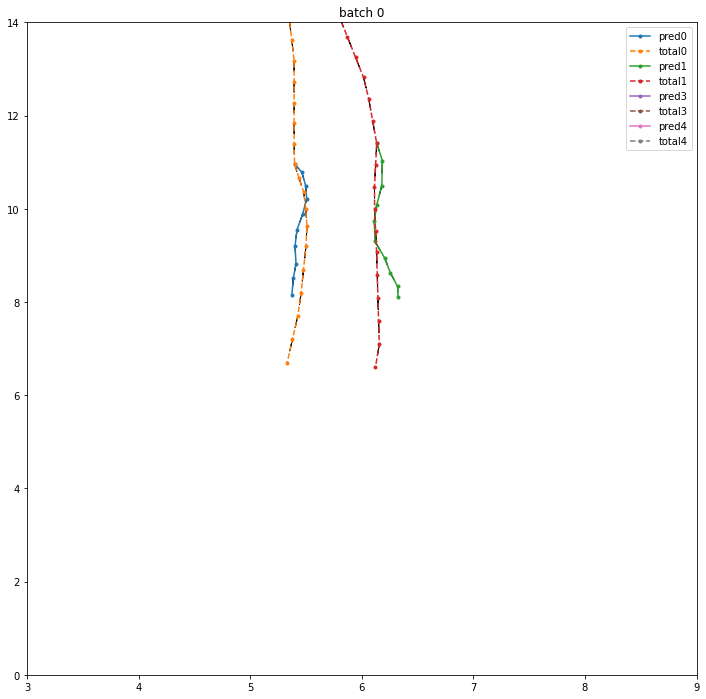

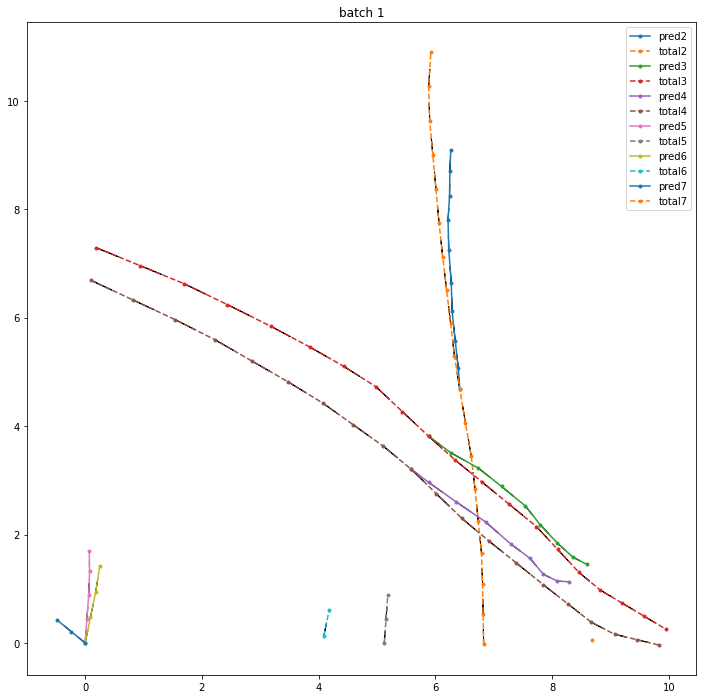

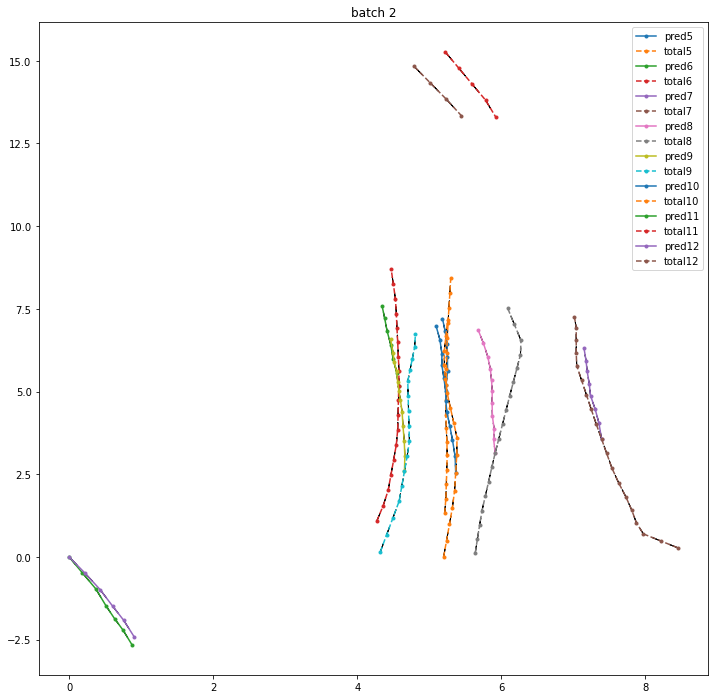

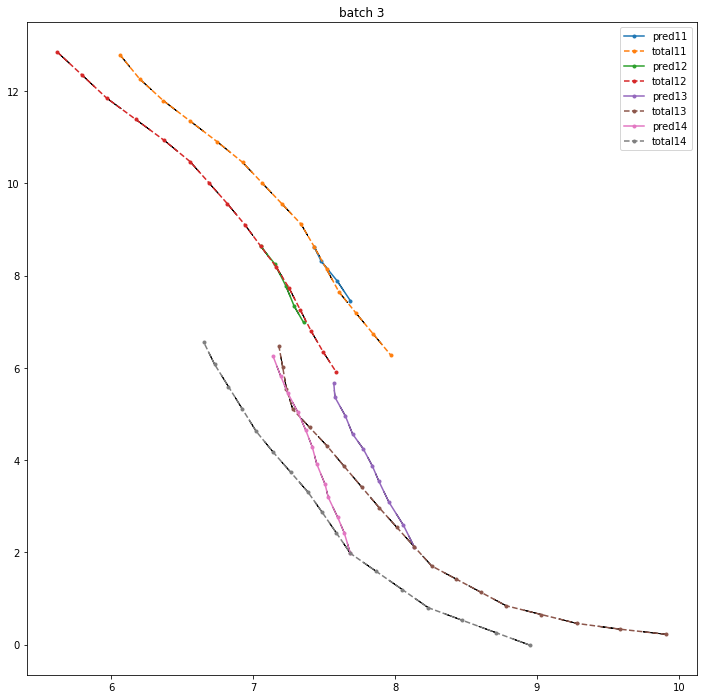

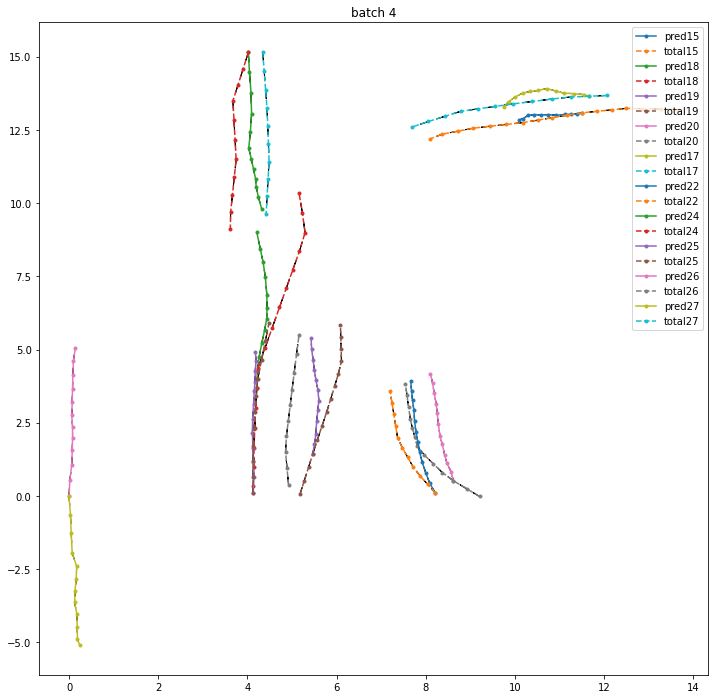

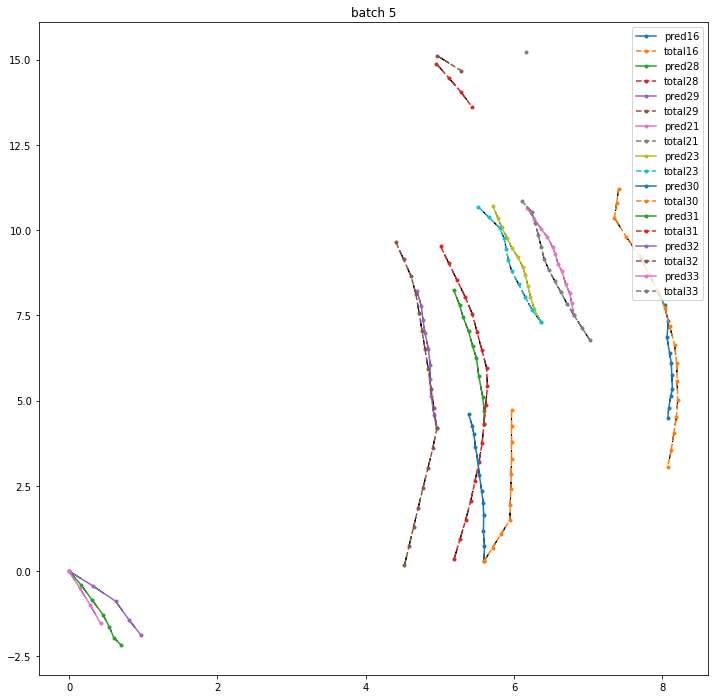

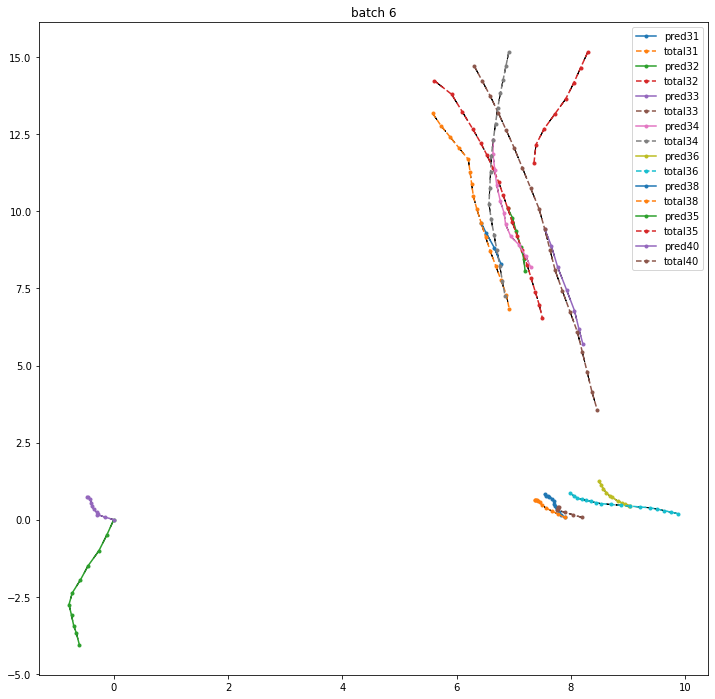

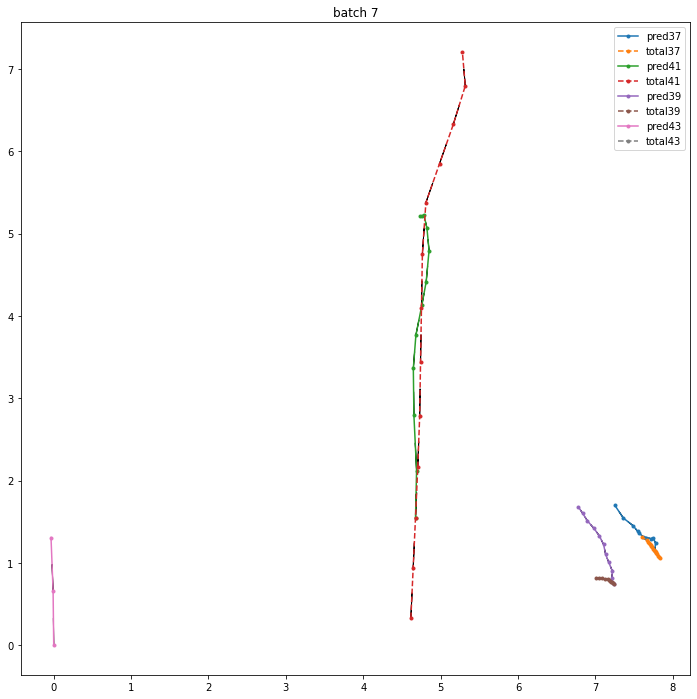

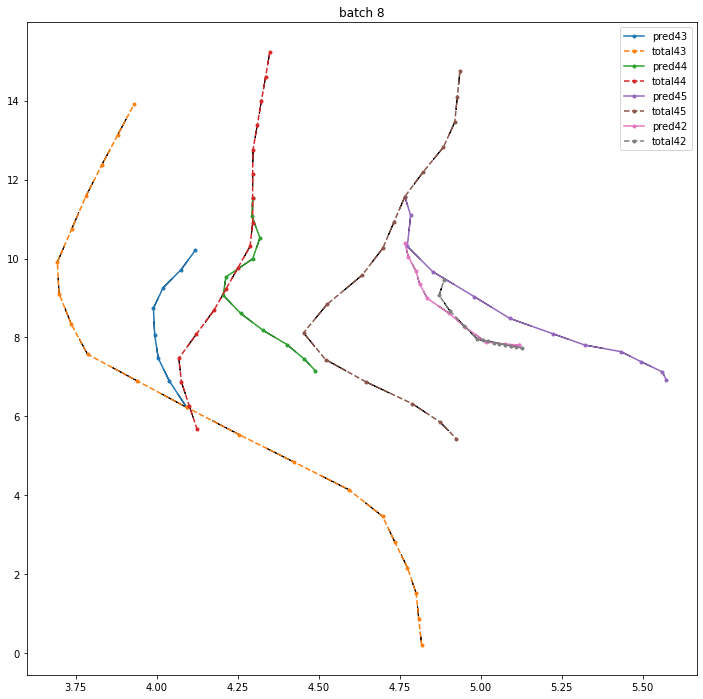

In [9]:
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"using {device}\n")
#     vl = train(8, 20)
    vl1 = torch.load("vl.pt")
    validate(vl1, 8, 20)